# **recurrent neural network**

### init

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

g = torch.Generator(device=device).manual_seed(0)

class EmbeddingsRNN:
    def __init__(self, embedding_dims, context_size, batch_size, hidden_units, device):
        self.batch_size = batch_size
        self.embedding_dims = embedding_dims
        self.context_size = context_size
        self.device = device
        self.hidden_units = hidden_units
        self.g = torch.Generator(device=self.device).manual_seed(0)
        self.C = torch.randn((28, self.embedding_dims), generator=self.g, device=self.device) * 0.01# embedding lookup-table
        self.Wxh = torch.randn((self.embedding_dims, self.hidden_units), generator=self.g, device=self.device) * (2/(self.embedding_dims))**0.5 # weights input to hidden
        self.Whh = torch.randn((self.hidden_units, self.hidden_units), generator=self.g, device=self.device) * (2/100)**0.5 # weights hidden to hidden
        self.bh = torch.randn((1, self.hidden_units), generator=self.g, device=self.device) * 0.01 # biases hidden layer
        self.Who = torch.randn((self.hidden_units, 28), generator=self.g, device=self.device) * (2/100)**0.5 # weights hidden to output
        self.bo = torch.randn(28, generator=self.g, device=self.device) * 0.01 # biases output layer
        self.parameters = [self.C, self.Wxh, self.Whh, self.bh, self.Who, self.bo]
        for p in self.parameters:
            p.requires_grad = True

    def forward(self, X, y):
        # X comes in as (batch_size, context_size, 28)
        # y comes in as (batch_size)
        ys = torch.cat((
            torch.argmax(X, dim=2)[:, 1:],
            torch.unsqueeze(y, dim=1)),
            dim=1) # (batch_size, context_size)

        embeddings, hs, logits = {}, {}, {}
        self.loss = 0
        hs[-1] = torch.zeros(self.batch_size, self.hidden_units, device=device)

        for t in range(self.context_size):
            embeddings[t] = X[:, t, :]@self.C # (batch_size, 1, 28) @ (28, embedding_dims) = (batch_size, embedding_dims)
            hs[t] = F.tanh(embeddings[t] @ self.Wxh + hs[t-1] @ self.Whh + self.bh) # (batch_size, hidden_units)
            logits[t] = hs[t] @ self.Who + self.bo # (batch_size, 1, 28)
            self.loss += F.cross_entropy(logits[t], ys[:, t])
        return self.loss.item()
            
    def backward(self):
        for p in self.parameters:
            p.grad = None
        self.loss.backward()

    def update_params(self, lr, clip_value=None):
        for p in self.parameters:
            if p.grad is not None:
                if clip_value is not None:
                    p.grad.data = torch.clamp(p.grad.data, -clip_value, clip_value)
                p.data += -lr * p.grad


    def sample(self, ctoi, itoc):
        text = ''
        n = 0
        nll = 0.0
        context = ['<>'] * self.context_size

        with torch.no_grad():
            while True:
                embeddings, hs, logits, probs, ixs = {}, {}, {}, [], []
                hs[-1] = torch.zeros_like(self.bh, device=device)
                X = F.one_hot(torch.tensor([ctoi[c] for c in context], device=self.device), num_classes=28).float()


                for t in range(self.context_size):
                    embeddings[t] = (X[t, :]@self.C)
                    hs[t] = F.tanh(embeddings[t] @ self.Wxh + hs[t-1] @ self.Whh + self.bh)
                    logits[t] = hs[t] @ self.Who + self.bo
                    probs.append(F.softmax(logits[t], dim=1))
                    ixs.append(torch.multinomial(probs[-1], num_samples=1, replacement=True, generator=self.g).item())

                # break if end-character was sampled
                if ixs[t]==ctoi['<>']:
                    break
                    
                # update params
                context = context[1:] + [itoc[ixs[-1]]]
                text += itoc[ixs[-1]]
                n += 1

                # calculate negative log loss
                p = probs[-1][0][ixs[-1]].log().item()
                nll -= p
            return text, nll/n

Using mps device


### initialize hyperparameters and dataset

In [2]:
from utils.data_util import HackerNewsContext
from torch.utils.data import DataLoader

embedding_dims = 8
context_size = 16
batch_size = 1024
hidden_units = 512

training_data = HackerNewsContext(train=True, context_size=context_size, number_of_strings=30000)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=False, drop_last=True)

### find initial learning rate

Text(0, 0.5, 'Negative Log Likelihood')

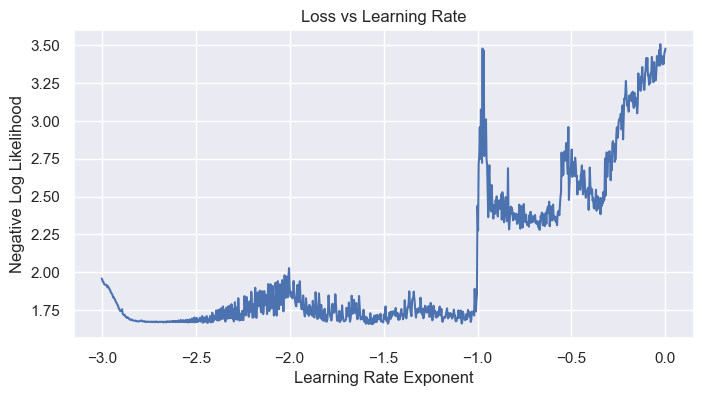

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

lr_exps = torch.linspace(-3, 0, 1000)
lrs = 10**lr_exps
iterator = iter(train_dataloader)
losses = []
nn1 = EmbeddingsRNN(embedding_dims=embedding_dims, context_size=context_size, batch_size=batch_size, hidden_units=hidden_units, device=device)

for lr in lrs:
    X, y = next(iterator)
    X, y = X.to(device), y.to(device) # (batch_size, context_size, 28)

    loss = nn1.forward(X=X, y=y)
    nn1.backward()
    nn1.update_params(lr=lr, clip_value=5.0)
    losses.append(loss)

fig, ax = plt.subplots(figsize=(8,4))
sns.set_style()
plt.plot(lr_exps, np.log10(losses))
ax.set_title('Loss vs Learning Rate')
ax.set_xlabel('Learning Rate Exponent')
ax.set_ylabel('Negative Log Likelihood')

### instantiate rnn

In [4]:
rnn = EmbeddingsRNN(
    embedding_dims=embedding_dims,
    context_size=context_size,
    batch_size=batch_size,
    hidden_units=hidden_units,
    device=device
)

### model training

In [5]:
lr = 10**-1.5
epochs = 10

for epoch in range(epochs):
    losses = []
    for batch, (X, y) in enumerate(train_dataloader):
        X = X.to(device)
        y = y.to(device)
        losses.append(rnn.forward(X, y))
        rnn.backward()
        rnn.update_params(lr=lr, clip_value=5.0)
    print(f'epoch: {epoch+1} --- average loss: {(np.mean(losses)/context_size):.4f}')
    if epochs/(epoch+1) == 2:
        lr /= 2

epoch: 1 --- average loss: 2.1633
epoch: 2 --- average loss: 1.9176
epoch: 3 --- average loss: 1.8373
epoch: 4 --- average loss: 1.7904
epoch: 5 --- average loss: 1.7593
epoch: 6 --- average loss: 1.7358
epoch: 7 --- average loss: 1.7258
epoch: 8 --- average loss: 1.7170
epoch: 9 --- average loss: 1.7092
epoch: 10 --- average loss: 1.7022


### sample from model

In [13]:
text, nll = rnn.sample(
    ctoi=training_data.ctoi,
    itoc=training_data.itoc
)
print(text)
print(f'negative log likelihood: {nll:.4f}')

it would pricated mypub exagos after who zell  provet in ktaller postmys tell interdo if you also experies a big comepso you can such iphe pr sust how the most like baint and chiromal note them that a hrefhttpgooglectarging agaze by anoumers forcasturnlashcatenspgoomsb couldpreason that wowin im resifacyve capi styll and when someone devereliait in dozal suching software dont funt vest my way who as carm enesable his sfarthis with littor is you unistion so to a seere commack in 
negative log likelihood: 1.7310
